In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [3]:
# Go to the base folder in drive
%cd /content/drive/MyDrive/datasets/
!ls

/content/drive/.shortcut-targets-by-id/1JRCiuPj_2FkyNqV_IF2jRT8gg49-YZAB/dataset
'Download track.gsheet'		        epic-kitchens-100-object-masks
 EPIC-KITCHENS			        epic-kitchens-download-scripts-master
 epic-kitchens-100-annotations-master   util
 epic-kitchens-100-hand-object-bboxes   video_feature_extractor


In [4]:
import sys, os
sys.path.append('/content/drive/MyDrive/datasets/epic-kitchens-100-hand-object-bboxes/src/public_lib')
import pandas as pd
import numpy as np
import cv2
import os
import re
import pickle
import sys, os
import tarfile
sys.path.append('/content/drive/MyDrive/datasets/util')

from typing import Union, List
from pathlib import Path
import re
from ipywidgets import interact, IntSlider, Layout


from epic_kitchens.hoa import load_detections, DetectionRenderer
import PIL.Image

import os
import numpy as np
import tarfile
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import get_tuple as gett

# libraries
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)


In [5]:
epic_kitchen_dataset_path = '/content/drive/MyDrive/datasets/EPIC-KITCHENS'
EPIC_KITCHEN_DATASET_PATH = epic_kitchen_dataset_path

# A dictionary {participant_id : [video_id]}
fp = open(os.path.join(epic_kitchen_dataset_path, 'participant_video_ids.p'), 'rb')
participant_video_ids = pickle.load(fp)

In [6]:
'''
Load the train and validation annotation csv file
'''
path = "/content/drive/MyDrive/datasets/epic-kitchens-100-annotations-master/"
train_path = path + "EPIC_100_train.csv"
val_path = path + "EPIC_100_validation.csv"
train_data = pd.read_csv(train_path, sep=',')
val_data = pd.read_csv(val_path, sep=',')

train_dict = dict()
val_dict = dict()
for i in range(97):
  train_dict[i] = dict()
for i in range(94):
  val_dict[i] = dict()


def get_bbox_count(video_id):
  p_id = video_id.split('_')[0]
  hand_objects_path = os.path.join(EPIC_KITCHEN_DATASET_PATH, p_id, \
                              'hand-objects', '{}.pkl'.format(video_id))
  if not os.path.exists(hand_objects_path):
    print("ERROR! File {} does not exist".format(hand_objects_path))
    return 0, []
  
  video_detections = list(load_detections(hand_objects_path))
  num_frames = len(video_detections)

  frame_hands_num = np.zeros(num_frames)
  frame_objects_num = np.zeros(num_frames)
  
  for frame_idx, frame_hand_object in enumerate(video_detections):
    frame_hands_num[frame_idx] = len(frame_hand_object.hands)
    frame_objects_num[frame_idx] = len(frame_hand_object.objects)
    
  return num_frames, frame_hands_num, frame_objects_num

def output_dict_to_file(d, filename):
  if os.path.exists(filename):
    os.remove(filename)
  with open(filename, 'wb+') as fp:
      pickle.dump(d, fp) 

In [7]:
video_id_bbox_count = {}
video_id_num_frames = {}

bbox_count_file = os.path.join(EPIC_KITCHEN_DATASET_PATH, 'video_id_bbox_count.p')
frame_num_file = os.path.join(EPIC_KITCHEN_DATASET_PATH, 'video_id_num_frames.p')

if os.path.exists(bbox_count_file) and os.path.exists(frame_num_file):
  fp = open(bbox_count_file, 'rb')
  video_id_bbox_count = pickle.load(fp)
  fp = open(frame_num_file, 'rb')
  video_id_num_frames = pickle.load(fp)
else:
  for p_id, video_ids in participant_video_ids.items():
    for video_id in video_ids:
      num_frames, frame_hands_num, frame_objects_num = get_bbox_count(video_id)
      print("Participant {} , video_id={}, has {} frames".format(p_id, video_id, num_frames))
      video_id_num_frames[video_id] = num_frames
      video_id_bbox_count[video_id] = (frame_hands_num, frame_objects_num)
  
  output_dict_to_file(video_id_bbox_count, bbox_count_file)
  output_dict_to_file(video_id_num_frames, frame_num_file)

In [8]:
gett.process(train_data, train_dict) #{0: {'pick-up': (video_id, start, end)}}
gett.process(val_data, val_dict)

In [9]:
def choose_word_from_each_cat(d):
  random_words_from_each_cat = []
  for cat_id, verb_d in d.items():
    N = len(verb_d)
    all_verbs = list(verb_d.keys())
    # random_words_from_each_cat.append(all_verbs[np.random.randint(0,N,1)[0]])
    if len(all_verbs) == 0:
      random_words_from_each_cat.append("")
    else:
      random_words_from_each_cat.append(all_verbs[0])
  return random_words_from_each_cat

train_cat_verb = choose_word_from_each_cat(train_dict)
val_cat_verb = choose_word_from_each_cat(val_dict)

In [10]:
NUM_CAT = max(np.max(list(train_dict.keys())), np.max(list(val_dict.keys()))) + 1

def process_clip_list_frame(d):
  mean_frame_per_cat = np.zeros(NUM_CAT)
  std_frame_per_cat = np.zeros(NUM_CAT)
  max_per_cat, min_per_cat = np.zeros(NUM_CAT), np.zeros(NUM_CAT)
  
  for cat_id, verb_d in d.items():
    acc = []
    if len(verb_d) == 0:
      print("No verb: ", cat_id)
    for verb, clip_list in verb_d.items():
      
      N = len(clip_list)
      num_frame_per_clip = np.zeros(N)

      i = 0
      for video_id,start,end in clip_list:
        num_frame_per_clip[i] = end-start+1
        i += 1
      acc.append(num_frame_per_clip)
    
    j = int(cat_id)
    if len(acc) == 0:
      
      max_per_cat[j] = 0
      min_per_cat[j] = 0
      mean_frame_per_cat[j] = 0
      std_frame_per_cat[j] = 0
    else:
      max_per_cat[j] = np.max(np.hstack(acc))
      min_per_cat[j] = np.min(np.hstack(acc))
      mean_frame_per_cat[j] = np.mean(np.hstack(acc))
      std_frame_per_cat[j] = np.std(np.hstack(acc))
  
  return min_per_cat, max_per_cat,mean_frame_per_cat, std_frame_per_cat

print("\nEmpty verb classes in Train: ")
tmin_per_cat, tmax_per_cat, tmean_frame_per_cat, tstd_frame_per_cat = process_clip_list_frame(train_dict)
print("\nEmpty verb classes in Validation: ")
vmin_per_cat, vmax_per_cat, vmean_frame_per_cat, vstd_frame_per_cat = process_clip_list_frame(val_dict)



Empty verb classes in Train: 

Empty verb classes in Validation: 
No verb:  50
No verb:  54
No verb:  58
No verb:  61
No verb:  62
No verb:  66
No verb:  73
No verb:  74
No verb:  76
No verb:  77
No verb:  79
No verb:  86
No verb:  87
No verb:  88
No verb:  91
No verb:  92


In [11]:
print("Non-existent verb classes in validation: ", set(list(train_dict.keys())) - set(list(val_dict.keys())))
print("(Training) Maxmimum number of frames for each verb class: ", tmax_per_cat)
print("(Training) Minimum number of frames for each verb class: ",tmin_per_cat)
print("(Training) Maxmimum number of frames for each verb class: ", vmax_per_cat)
print("(Training) Minimum number of frames for each verb class: ",vmin_per_cat)

Non-existent verb classes in validation:  {96, 94, 95}
(Training) Maxmimum number of frames for each verb class:  [ 3026.  2930.  7630.  2551.  2857.  2596.  1265. 14858. 12421.  3495.
  5171.  1806. 10073.  1535.  1843.  1110.  2956.  2362.  2274.  4348.
  2561.  1723.  2596.  3974.  1520.  1931.  2152.  5026.  1096.  1409.
  2083.   530.  1037.  2442.  3292.  1120.  1472.  2059.  1736.   874.
  1583.  1111.  2326.  1208.  1614.  4763.  1559.  1816.  2143.  7889.
  2035.  2881.  7911.  1269.   662.  1060.   565.  3190.  1516.  5052.
   745.  1810.   295.  1120.   493.  1030.  1607.   653.   859.  1311.
  1111.   412.  2991.   591.  1357.   340.   468.  2935.  2407.   788.
   501.   778.  2115.   161.  1164.   370.   272.   827.   897.   711.
   486.   201.  2166.    87.   542.    29.   939.]
(Training) Minimum number of frames for each verb class:  [ 11.  11.  11.  13.  12.  13.  11.  17.  11.  14.  30.  13.  19.  13.
  15.  14.  21.  25.  14.  19.  15.  19.  18.  18.  25.  29.  28.  

In [12]:
# print(np.where(tmean_frame_per_cat > 500))

def print_verbs_in_most_least_frames(mean_frame_per_cat, other_mean, d):
  '''
  According to the average number of frames for a training/validation sample of
  a given verb class, print the verbs in those verb classes
  '''
  top_num = 15
  most_num_frame = np.argsort(mean_frame_per_cat)[::-1]
  least_num_frame = np.argsort(mean_frame_per_cat)

  most_other = np.argsort(other_mean)[::-1]
  least_other = np.argsort(other_mean)

  idx = 0
  count = 0
  while count < top_num:
    i = most_num_frame[idx]
    if len(d.get(i,{})) > 0:
      verbs = list(d[i].keys())
      print("With highest average frames: ", i, verbs, mean_frame_per_cat[i], " ,rank in other: ",np.where(most_other == i)[0][0]+1)
      count += 1
    idx += 1
  
  print("----------------------------------------------------------")
  
  idx = 0
  count = 0
  while count < top_num:
    i = least_num_frame[idx]
    if len(d.get(i,{})) > 0:
      verbs = list(d[i].keys())
      print("With lowest average frames: ", i, verbs, mean_frame_per_cat[i], " ,rank in other: ",np.where(least_other == i)[0][0]+1)
      count += 1
    idx += 1

print("\nTraining: ")
print_verbs_in_most_least_frames(tmean_frame_per_cat, vmean_frame_per_cat, train_dict)
print("\nValidation: ")
print_verbs_in_most_least_frames(vmean_frame_per_cat, tmean_frame_per_cat, val_dict)

ttop_num_frame = np.argsort(tmean_frame_per_cat)[::-1]
vtop_num_frame = np.argsort(vmean_frame_per_cat)[::-1]


Training: 
With highest average frames:  77 ['grate', 'grate-on', 'grate-into', 'zest-into', 'grate-onto'] 1108.28  ,rank in other:  85
With highest average frames:  72 ['wait-for', 'wait', 'decide'] 1032.6363636363637  ,rank in other:  2
With highest average frames:  92 ['prepare', 'prepare-for'] 951.25  ,rank in other:  81
With highest average frames:  51 ['knead'] 926.9019607843137  ,rank in other:  11
With highest average frames:  82 ['serve', 'serve-in', 'serve-on', 'dish', 'plate-up'] 747.5  ,rank in other:  8
With highest average frames:  52 ['separate', 'split', 'divide-into', 'unattach', 'separate-from', 'divide', 'disassemble', 'split-into'] 649.4411764705883  ,rank in other:  1
With highest average frames:  10 ['stir', 'stir-into', 'mix', 'stir-in', 'stir-with', 'mix-with', 'mix-into', 'mix-in', 'blend', 'whisk', 'mix-so', 'whisk-in', 'fold-in', 'scramble', 'beat'] 602.9364675984752  ,rank in other:  6
With highest average frames:  49 ['grind', 'crush', 'soften', 'grind-int

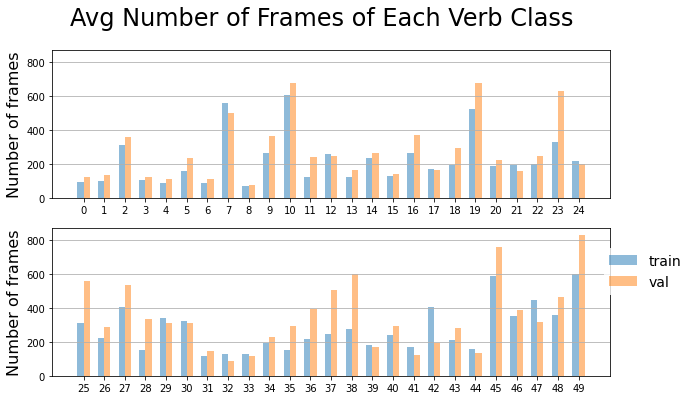

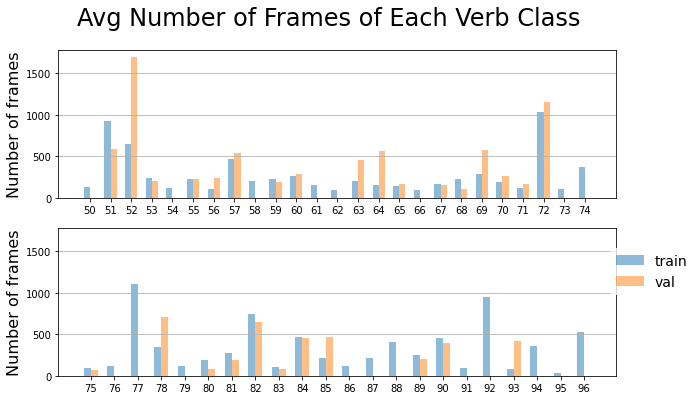

In [13]:
# def generate_frame_bar_plot(min_per_cat, max_per_cat, mean_frame_per_cat, std_frame_per_cat):
# num_row = (NUM_CAT // 50) + 1

start_end = [(0,25),(25,50),(50,75),(75,97)]
k = 0
for _ in range(2):
  fig = plt.figure(figsize=(10, 6))
  gs = fig.add_gridspec(2, 1)
  st = plt.suptitle('Avg Number of Frames of Each Verb Class', fontsize=24)

  barWidth = 0.3
  ax1 = None
  for i in range(2):
    for j in range(1):
      # start_idx = (2*i+j)*25
      # end_idx = start_idx+25 if (start_idx+25) <= NUM_CAT else NUM_CAT
      start_idx, end_idx = start_end[k]
      x_tick_labels = np.arange(start_idx, end_idx)

      bar_pos_train = np.arange(len(x_tick_labels))
      bar_pos_val = np.arange(len(x_tick_labels)) + barWidth

      
      if i==0 and j==0:
        ax = fig.add_subplot(gs[i, j])
        ax1 = ax
      else:
        ax = fig.add_subplot(gs[i, j],sharey=ax1)
        
      ax.bar(bar_pos_train, tmean_frame_per_cat[start_idx: end_idx], \
              align='center', width=barWidth, alpha=0.5, ecolor='black', capsize=10, label='train')
      
      ax.bar(bar_pos_val, vmean_frame_per_cat[start_idx: end_idx], \
              align='center', width=barWidth, alpha=0.5, ecolor='black', capsize=10, label='val')
      
      ax.set_ylabel('Number of frames', fontsize=16)
      ax.set_xticks(np.arange(len(x_tick_labels))+barWidth/2)
      ax.set_xticklabels(x_tick_labels)
      # ax[i,j].set_title('Number of Frames per Verb Category')
      ax.yaxis.grid(True)
      k+=1

  leg = plt.legend(loc = 'lower right', bbox_to_anchor=(1.15, 0.5), fontsize=14)
  leg.get_frame().set_linewidth(0.0)
  plt.savefig(os.path.join('/content/drive/MyDrive/datasets/', 'util', 'figures', 'avg_number_frames_verb_class_{}.png'.format(k)))
  plt.show()

Total number of videos:  700


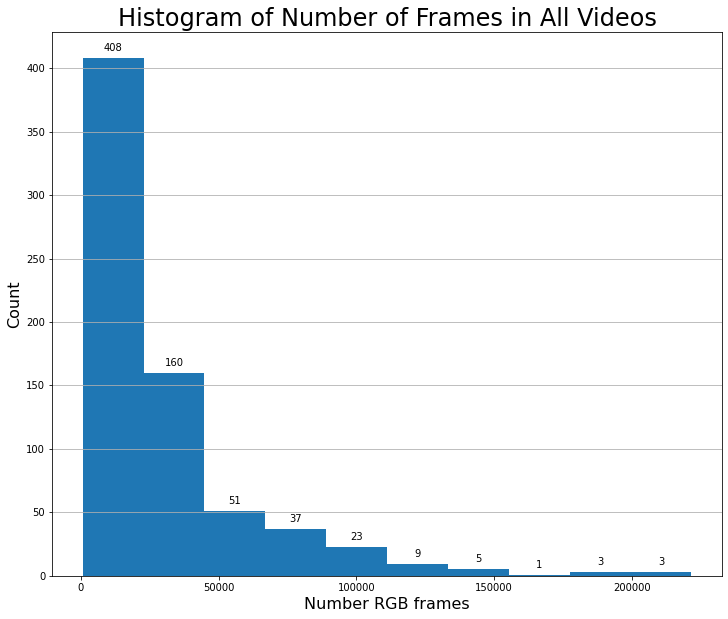

In [14]:
print("Total number of videos: ", len(video_id_num_frames))

fig, ax = plt.subplots(figsize=(12, 10))
ax.hist(video_id_num_frames.values(), density=False)

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 
ax.set_ylabel('Count',fontsize=16)
ax.set_xlabel('Number RGB frames',fontsize=16)
ax.set_title("Histogram of Number of Frames in All Videos",fontsize=24)
ax.yaxis.grid(True)
fig.savefig(os.path.join('/content/drive/MyDrive/datasets/', 'util', 'figures', 'histogram_num_frame_videos.png'))


In [15]:
hand_acc = []
obj_acc = []
for _,(frame_hands_num, frame_objects_num) in video_id_bbox_count.items():
  hand_acc.append(np.max(frame_hands_num))
  obj_acc.append(np.max(frame_objects_num))

MAX_NUM_HAND = np.max(hand_acc).astype('int')
MAX_NUM_OBJ = np.max(obj_acc).astype('int')

print("Maximum number of hand bbox in any frames: {}".format(MAX_NUM_HAND))
print("Maximum number of object bbox in any frames: {}".format(MAX_NUM_OBJ))

Maximum number of hand bbox in any frames: 8
Maximum number of object bbox in any frames: 11


In [16]:
def top_num_clip(d):
  num_clip = np.zeros(NUM_CAT)
  for cat_id, verb_d in d.items():
    cat_idx = int(cat_id)
    if len(verb_d) == 0:
      continue
    acc = 0
    for verb, clip_list in verb_d.items():
      if len(clip_list) == 0:
        continue
      acc += len(clip_list)
    num_clip[cat_idx] = acc
  return np.argsort(num_clip)[::-1]

ttop_num_clip = top_num_clip(train_dict)
vtop_num_clip = top_num_clip(val_dict)

print("Train, sorted verb classes with the most number of samples: ", ttop_num_clip)
print("Validation, orted verb classes with the most number of samples: ",vtop_num_clip)

Train, sorted verb classes with the most number of samples:  [ 0  1  2  3  4  5  6  8  7 11  9 10 12 13 14 15 17 19 18 16 21 22 20 24
 23 26 25 29 27 30 28 34 33 32 35 37 39 31 36 40 38 44 41 48 42 47 50 43
 58 55 45 46 52 57 53 49 54 59 61 56 66 60 63 51 64 62 67 69 68 65 74 76
 72 73 75 70 79 77 78 71 86 87 85 82 80 88 84 81 83 89 91 92 94 95 90 96
 93]
Validation, orted verb classes with the most number of samples:  [ 0  1  2  3  5  4  6  7 10  9 12  8 11 13 14 15 17 19 16 18 20 27 24 23
 26 46 36 51 28 21 47 29 35 56 45 37 44 40 81 53 49 67 34 31 30 42 22 71
 57 41 33 38 25 48 43 52 84 90 32 60 82 69 63 59 83 65 85 64 80 78 39 68
 55 93 89 70 72 75 94 88 86 87 91 92 73 79 77 76 74 95 66 62 61 58 54 50
 96]


In [17]:
def process_cat_bbox_hist(d, video_id_bbox_count, hand_or_obj):
  '''
  Get a histogram of number of hand/object bounding boxes for each 
  verb classes
  '''
  if hand_or_obj == "hand":
    bins = np.arange(MAX_NUM_HAND+2)
    count_arr = np.zeros((NUM_CAT, MAX_NUM_HAND+1))
  else:
    bins = np.arange(MAX_NUM_OBJ+2)
    count_arr = np.zeros((NUM_CAT, MAX_NUM_OBJ+1)) 
  
  for cat_id, verb_d in d.items():
    cat_idx = int(cat_id)
    if len(verb_d) == 0:
      continue
    if hand_or_obj == "hand":
      acc = np.zeros(MAX_NUM_HAND+1)
    else:
      acc = np.zeros(MAX_NUM_OBJ+1)
    
    for verb, clip_list in verb_d.items():
      if len(clip_list) == 0:
        continue
      for video_id,start,end in clip_list: 
        hand_bbox_count, obj_bbox_count = video_id_bbox_count[video_id]
        if hand_or_obj == "hand":
          count,_ = np.histogram(hand_bbox_count[start:end+1], bins=bins)
          acc = acc + count
        else:
          count,_ = np.histogram(obj_bbox_count[start:end+1], bins=bins)
          acc = acc + count
    count_arr[cat_idx] = acc
  return count_arr
  

train_hand_hist = process_cat_bbox_hist(train_dict, video_id_bbox_count, "hand")
train_obj_hist = process_cat_bbox_hist(train_dict, video_id_bbox_count, "obj")
val_hand_hist = process_cat_bbox_hist(val_dict, video_id_bbox_count, "hand")
val_obj_hist = process_cat_bbox_hist(val_dict, video_id_bbox_count, "obj")

In [18]:
def process_cat_bbox(d, video_id_bbox_count, hand_or_obj):
  '''
  Get mean, std, maximum, and minimum number of hand/object
  bounding boxes of samples in a given verb class
  '''
  mean_bbox_per_cat = np.zeros(NUM_CAT)
  std_bbox_per_cat = np.zeros(NUM_CAT)
  max_per_cat, min_per_cat = np.zeros(NUM_CAT), np.zeros(NUM_CAT)

  for cat_id, verb_d in d.items():
    cat_idx = int(cat_id)
    if len(verb_d) == 0:
      mean_bbox_per_cat[cat_idx] = 0
      std_bbox_per_cat[cat_idx] = 0
      max_per_cat[cat_idx], min_per_cat[cat_idx] = 0,0
      continue
    acc = []
    for verb, clip_list in verb_d.items():
      if len(clip_list) == 0:
        continue
      for video_id,start,end in clip_list: 
        hand_bbox_count, obj_bbox_count = video_id_bbox_count[video_id]
        if hand_or_obj == "hand":
          acc.append(hand_bbox_count[start:end+1])
        else:
          acc.append(obj_bbox_count[start:end+1])

    mean_bbox_per_cat[cat_idx] = np.mean(np.hstack(acc))
    std_bbox_per_cat[cat_idx] = np.std(np.hstack(acc))
    max_per_cat[cat_idx], min_per_cat[cat_idx] = np.max(np.hstack(acc)),np.min(np.hstack(acc))
  
  return min_per_cat, max_per_cat, mean_bbox_per_cat, std_bbox_per_cat

In [19]:
tmin_per_cat, tmax_per_cat, tmean_bbox_per_cat, tstd_bbox_per_cat = process_cat_bbox(train_dict, video_id_bbox_count, "hand")
vmin_per_cat, vmax_per_cat, vmean_bbox_per_cat, vstd_bbox_per_cat = process_cat_bbox(val_dict, video_id_bbox_count, "hand")

In [20]:
tmin_per_cat_obj, tmax_per_cat_obj, tmean_bbox_per_cat_obj, tstd_bbox_per_cat_obj = process_cat_bbox(train_dict, video_id_bbox_count, "obj")
vmin_per_cat_obj, vmax_per_cat_obj, vmean_bbox_per_cat_obj, vstd_bbox_per_cat_obj = process_cat_bbox(val_dict, video_id_bbox_count, "obj")

print("Traning, maximum number of object bbox: ", tmax_per_cat_obj)
print("Training: average number of object bbox:", tmean_bbox_per_cat_obj)
print("Validation, maximum number of object bbox: ", vmax_per_cat_obj)
print("Validation: average number of object bbox:", vmean_bbox_per_cat_obj)

Traning, maximum number of object bbox:  [11. 10. 11.  8.  9. 10. 10. 10. 10. 10. 10.  9.  9.  8.  7.  8.  8.  9.
  7.  8.  8.  7.  8. 10.  7.  8.  7.  8.  8.  9.  8.  7.  7.  8.  7.  7.
  8.  7.  7.  8.  8.  7.  8.  9.  8.  8.  9.  7.  9.  9.  6.  6.  8.  9.
  8.  8.  8.  6.  9.  6.  5.  7.  8.  8.  7.  6.  8.  6.  7.  7.  7.  5.
  5.  7.  6.  4.  7.  7.  6.  6.  5.  6.  7.  5.  7.  7.  6.  6.  6.  6.
  4.  5.  5.  1.  6.  2.  5.]
Training: average number of object bbox: [1.8376 1.8594 1.9847 1.7306 1.5188 2.0223 2.2491 2.5011 2.1303 2.149
 2.2608 2.0933 2.0796 1.8762 1.3337 1.7531 2.0461 2.1694 1.9011 2.0292
 1.9483 2.0428 2.499  2.4593 1.7947 2.2231 2.244  2.1305 1.5497 1.8764
 1.9513 1.6522 2.2216 2.0996 2.1747 1.141  1.8968 1.8303 1.2188 2.0419
 2.2502 1.6157 2.1398 2.16   2.5831 2.4984 2.2241 2.0617 1.5989 1.8184
 1.2236 1.8705 2.6091 1.9531 2.0815 2.0424 1.7725 1.7939 3.0847 2.0795
 0.8688 2.1766 2.6509 2.2329 1.8431 2.0295 1.8924 0.9174 1.2623 2.1339
 1.93   1.6902 0.9255 2.047

In [21]:
def plot_bbox_histogram(tmean_bbox_per_cat, vmean_bbox_per_cat, Hand_or_Obj):
  # num_row = (NUM_CAT // 50) + 1
  start_end = [(0,25),(25,50),(50,75),(75,97)]
  k = 0
  for _ in range(2):
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(2, 1)
    st = fig.suptitle('Avg Number of {} BBox of Each Verb Class'.format(Hand_or_Obj), fontsize=24)

    barWidth = 0.3
    ax1 = None
    for i in range(2):
      for j in range(1):
        # start_idx = (2*i+j)*25
        # end_idx = start_idx+25 if (start_idx+25) <= NUM_CAT else NUM_CAT
        start_idx,end_idx = start_end[k]
        x_tick_labels = np.arange(start_idx, end_idx)
        bar_pos_train = np.arange(len(x_tick_labels))
        bar_pos_val = np.arange(len(x_tick_labels)) + barWidth
        
        if i==0 and j==0:
          ax = fig.add_subplot(gs[i, j])
          ax1 = ax
        else:
          ax = fig.add_subplot(gs[i, j],sharey=ax1)
          
        ax.bar(bar_pos_train, tmean_bbox_per_cat[start_idx: end_idx], \
                align='center', width=barWidth, alpha=0.5, ecolor='black', capsize=10, label='train')
        
        ax.bar(bar_pos_val, vmean_bbox_per_cat[start_idx: end_idx], \
                align='center', width=barWidth, alpha=0.5, ecolor='black', capsize=10, label='val')
        
        ax.set_ylabel('Number of {} BBox'.format(Hand_or_Obj), fontsize=14)
        ax.set_xticks(np.arange(len(x_tick_labels))+barWidth/2)
        ax.set_xticklabels(x_tick_labels)
        ax.yaxis.grid(True)
        k += 1
    # st.set_y(1.02)
    # fig.subplots_adjust(top=0.85)
    # fig.tight_layout()

    leg = plt.legend(loc = 'lower right', bbox_to_anchor=(1.15, 0.5), fontsize=14)
    leg.get_frame().set_linewidth(0.0)
    fig.savefig(os.path.join('/content/drive/MyDrive/datasets/', 'util', 'figures', 'avg_number_{}_bbox_verb_class_{}.png'.format(Hand_or_Obj, k//2)))
    plt.show()

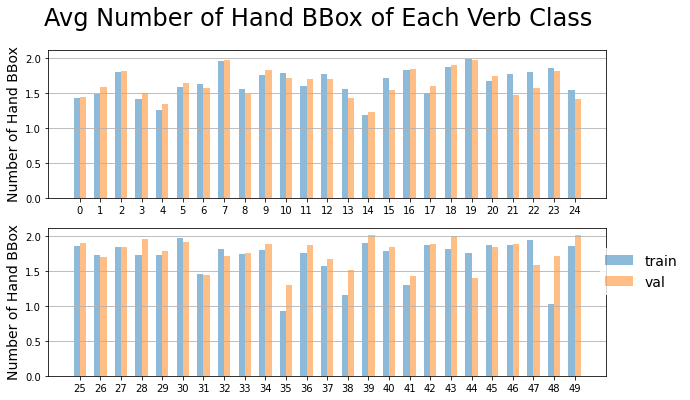

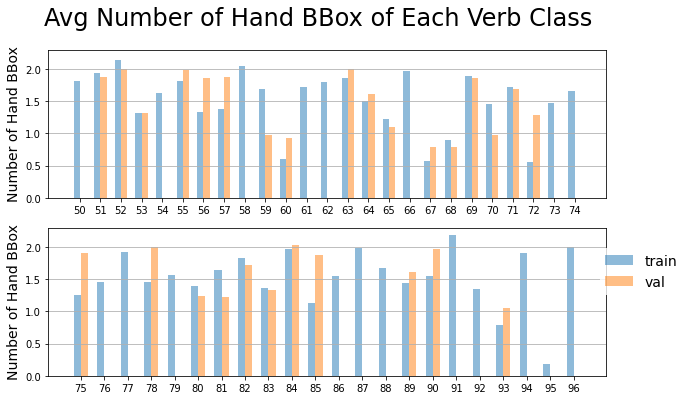

In [22]:
plot_bbox_histogram(tmean_bbox_per_cat, vmean_bbox_per_cat, "Hand")

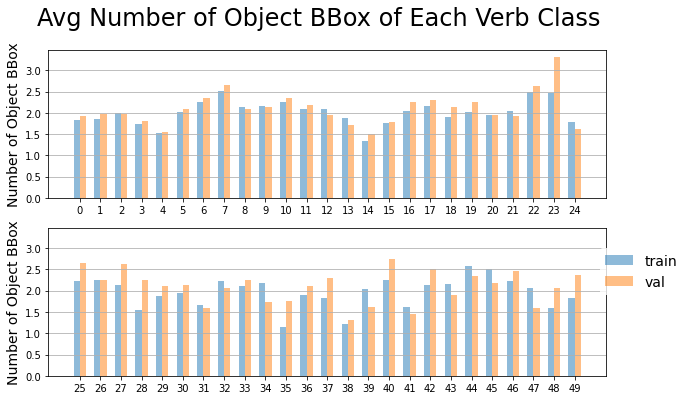

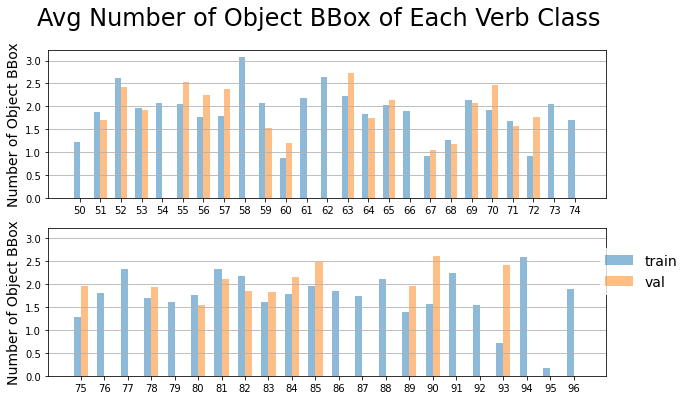

In [23]:
plot_bbox_histogram(tmean_bbox_per_cat_obj, vmean_bbox_per_cat_obj, "Object")

In [24]:
def print_verb_list(d, cat_id_list):
  for cat_id in cat_id_list:
    if len(d.get(cat_id,{})) == 0:
      print(cat_id, "[]")
      continue
    print(cat_id, list(d[cat_id].keys()))

print("Number of verb category with less than 1.5 hands: ", np.sum(tmean_bbox_per_cat < 1.5))
print("Training set: \n")
print_verb_list(train_dict, list(np.where(tmean_bbox_per_cat < 1.5)[0]))

print("\nNumber of verb category with more than 1.5 hands: ", np.sum(tmean_bbox_per_cat >= 1.5))
print("Training set: \n")
print_verb_list(train_dict, list(np.where(tmean_bbox_per_cat >= 1.5)[0]))

print("\n")
print("Number of verb category with less than 1.5 hands: ", np.sum(vmean_bbox_per_cat < 1.5))
print("Validation set: \n")
print_verb_list(val_dict, list(np.where(vmean_bbox_per_cat < 1.5)[0]))

Number of verb category with less than 1.5 hands:  30
Training set: 

0 ['take', 'draw', 'take-from', 'pick-up', 'grab', 'pick', 'take-up', 'get', 'take-into', 'pick-from', 'get-from', 'catch', 'take-of', 'collect-from', 'remove-on', 'pull-off', 'pick-off', 'retrieve', 'get-off', 'take-in', 'take-to', 'fetch', 'grab-up', 'unload', 'take-with', 'take-inside', 'grab-down', 'take-on', 'take-down', 'collect-into', 'get-with']
1 ['put-on', 'put-down', 'put-onto', 'put', 'put-back', 'place', 'lay-down', 'put-unto', 'mushroom-onto', 'place-onto', 'lay-onto', 'lay', 'return-into', 'return', 'put-under', 'put-with', 'put-of', 'leave-in', 'leave', 'place-on', 'rest-onto', 'rest-on', 'leave-with', 'return-from', 'put-to', 'create', 'put-away', 'tip', 'lay-out', 'lay-on', 'tuck-under', 'put-around', 'put-over', 'rest-against', 'store', 'place-back', 'put-for', 'place-down', 'place-up', 'place-away', 'replace', 'place-under', 'get-into', 'combine-from', 'put-outside', 'put-from', 'store-in', 'put-a

In [25]:
threshold = 1.8
print("\n")
print("Number of verb class with less than {} objects: ".format(threshold), np.sum(tmean_bbox_per_cat_obj < threshold))
print("Percentage of verb class with >= {} objects: ".format(threshold), (np.sum(tmean_bbox_per_cat_obj >= threshold)) / len(tmean_bbox_per_cat_obj))
print("Training set: \n")
print_verb_list(train_dict, list(np.where(tmean_bbox_per_cat_obj < threshold)[0]))

print("\n")
print("Number of verb class with less than {} objects: ".format(threshold), np.sum(vmean_bbox_per_cat_obj < threshold))
print("Validation set: \n")
print_verb_list(val_dict, list(np.where(vmean_bbox_per_cat_obj < threshold)[0]))



Number of verb class with less than 1.8 objects:  32
Percentage of verb class with >= 1.8 objects:  0.6701030927835051
Training set: 

3 ['open', 'open-with', 'open-up', 'open-on', 'uncork', 'open-to', 'unzip']
4 ['close', 'screw-on', 'screw-onto', 'close-off', 'close-on', 'shut', 'twist-on']
14 ['dry', 'dry-with', 'dry-on', 'dry-off']
15 ['shake', 'shake-with', 'shake-off', 'waft', 'swirl-in', 'shake-out', 'jiggle', 'shake-onto', 'shake-over', 'shake-on', 'swirl']
24 ['check', 'test', 'check-in', 'realize', 'look-in', 'examine', 'inspect', 'check-on', 'count', 'watch']
28 ['fold', 'fold-over', 'fold-up', 'fold-into']
31 ['pull-down', 'pull', 'pull-out', 'pull-up', 'pull-from', 'pull-through', 'pull-on']
35 ['taste', 'eat', 'swallow', 'lick', 'chew-on', 'bite', 'eat-from', 'sample']
38 ['see', 'read', 'read-on', 'look-at', 'look', 'see-off', 'look-behind', 'look-under', 'look-through']
41 ['hang', 'hand', 'hang-on', 'hang-up']
48 ['look-for', 'search', 'search-in', 'search-for', 'rum

In [26]:
'''
Generate
{participant_id : [video_id]}
to pickle file

ONLY DO THIS ONCE SO NOT TO KEEP ITERATING THROUGH FOLDERS 
'''
# import cv2
# import os
# import re 
# import pickle

# epic_kitchen_dataset_path = '/content/drive/MyDrive/datasets/EPIC-KITCHENS'

# participant_video_ids = {}
# participant_ids = []

# for obj_det_file in os.listdir(os.path.join(epic_kitchen_dataset_path)):
#   if obj_det_file[0] == 'P':
#     participant_ids.append(obj_det_file)

# for participant_id in participant_ids:
#   video_ids = []
#   hand_objects_path = os.path.join(epic_kitchen_dataset_path, participant_id, \
#                                 'hand-objects')
#   if os.path.exists(hand_objects_path):
#     for obj_det_file in os.listdir(hand_objects_path):
#       if obj_det_file[-3:] == 'pkl' and re.match("^[A-Za-z0-9_-]*$", obj_det_file[:-4]):
#         video_ids.append(obj_det_file.split(".")[0])
#     participant_video_ids[participant_id] = video_ids

# participant_video_file = os.path.join(epic_kitchen_dataset_path, 'participant_video_ids.p')
# if os.path.exists(participant_video_file):
#   os.remove(participant_video_file)
# with open(os.path.join(epic_kitchen_dataset_path, 'participant_video_ids.p'), 'wb+') as fp:
#     pickle.dump(participant_video_ids, fp) #protocol=pickle.HIGHEST_PROTOCOL

'\nGenerate\n{participant_id : [video_id]}\nto pickle file\n\nONLY DO THIS ONCE SO NOT TO KEEP ITERATING THROUGH FOLDERS \n'

In [27]:
'''
Visualizing the bounding boxes
'''
class LazyFrameLoader:
    def __init__(self, path, frame_template= 'frame_{:010d}.jpg'):
        self.path = path
        self.frame_template = frame_template
        
    def __getitem__(self, idx):
        return PIL.Image.open(os.path.join(self.path, self.frame_template.format(idx + 1)))

In [28]:
'''
WARNING:
!!! Pxx_video_id.tar must be untar first, otherwise .. no good and no use ...
'''
def bbox_visualize(p_id, video_id, frame_idx):
  # renderer has a problem cannot show in functin..?
  # p_id, video_id, frame_idx = 'P31', 'P31_01', 28174
  hand_objects_path = os.path.join(EPIC_KITCHEN_DATASET_PATH, p_id, \
                              'hand-objects', '{}.pkl'.format(video_id))
  video_detections = list(load_detections(hand_objects_path))

  frame_path = os.path.join(EPIC_KITCHEN_DATASET_PATH, p_id, 'rgb_frames', video_id)
  frames = LazyFrameLoader(frame_path)
  renderer = DetectionRenderer(hand_threshold=0.1, object_threshold=0.1)

  frame_template  = 'frame_{:010d}.jpg'
  frame_image_path = os.path.join(EPIC_KITCHEN_DATASET_PATH, p_id, 'rgb_frames', video_id, frame_template.format(frame_idx + 1))
  print("Showing image: ", frame_image_path)

  img = mpimg.imread(frame_image_path)
  fig = plt.figure(figsize=(15, 40))
  plt.imshow(img)
  plt.show()
  return renderer.render_detections(frames[frame_idx], video_detections[frame_idx])

Showing image:  /content/drive/MyDrive/datasets/EPIC-KITCHENS/P31/rgb_frames/P31_01/frame_0000028175.jpg


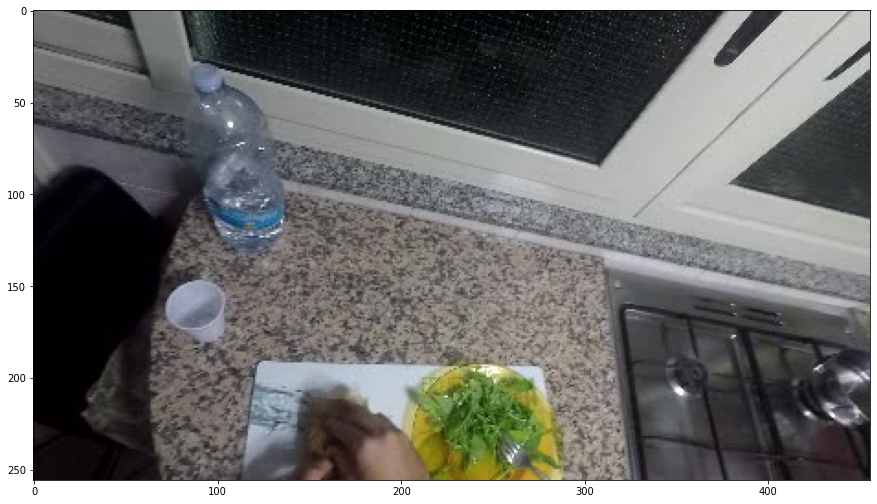

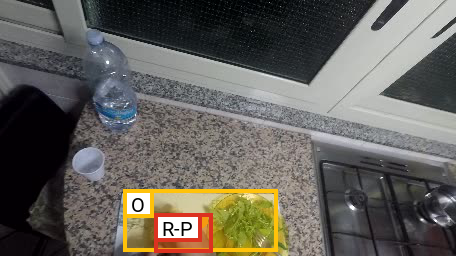

In [29]:
bbox_visualize('P31', 'P31_01', 28174)